**CMB emulator training tutorial-compressed way**\
This tutorial goes through how to train an emulator for CMB power spectrum. This tutorial, different from the other tutorial for training, compress the codes of defining models and training process in a package called **emulator**. This one is intended to be more user-friendly, while the other one is intended more for people to understand the process of developing the code and can modify codes according to their own need. We use CMB TT power spectrum as the example here, and same strategies will apply to EE and TE. 

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import scipy
import camb
import scipy.linalg
from camb import model, initialpower
from camb.dark_energy import DarkEnergyPPF, DarkEnergyFluid
import emulator
from emulator import Supact, Affine, Better_Attention, Better_Transformer, ResBlock, ResMLP, TRF, train

In [34]:
##### SET UP CMB POWER SPECTRA RANGE #####

camb_ell_min          = 2
camb_ell_max          = 202
camb_ell_range        = camb_ell_max - camb_ell_min

##### PICK DEVICE ON WHICH THE MODEL WILL BE TRAINED ON. WE RECOMMEND USING GPU FOR TRAINING #####
device                = torch.device("cpu")
#CUDA for GPU
#CPU for CPU
#GPU is generally recommended for higher speed.


In [35]:
##### LOAD UP MEAN AND STD FOR INPUT AND OUTPUT #####
extrainfo=np.load("Demo/extra_demo_omm.npy",allow_pickle=True)
X_mean=torch.Tensor(extrainfo.item()['X_mean'][:,:200])#.to(device)
X_std=torch.Tensor(extrainfo.item()['X_std'][:,:200])#.to(device)
Y_mean=torch.Tensor(extrainfo.item()['Y_mean'][:,:200]).to(device)
Y_std=torch.Tensor(extrainfo.item()['Y_std'][:,:200]).to(device)

##### LOAD UP COV MAT #####
covinv=np.load('Demo/cosvarinvTT.npy',allow_pickle=True)[:camb_ell_range,:camb_ell_range]
covinv=torch.Tensor(covinv).to(device) #This is inverse of the Covariance Matrix


#load in data
train_samples=np.load('Demo/cos_omm_train.npy',allow_pickle=True)

validation_samples=np.load('Demo/cos_omm_vali.npy',allow_pickle=True)

train_data_vectors=np.load('Demo/cos_omm_train_TT.npy',allow_pickle=True)[:,:200]

validation_data_vectors=np.load('Demo/cos_omm_vali_TT.npy',allow_pickle=True)[:,:200]
train_samples=torch.Tensor(train_samples)
train_data_vectors=torch.Tensor(train_data_vectors)
validation_samples=torch.Tensor(validation_samples)
validation_data_vectors=torch.Tensor(validation_data_vectors)
#specifying input and output dimension of our model
input_size=len(train_samples[0])
out_size=len(train_data_vectors[0])



#normalizing samples and to mean 0, std 1

X_train=(train_samples-X_mean)/X_std

X_validation=(validation_samples-X_mean)/X_std

X_train=X_train.to(torch.float32)
X_validation=X_validation.to(torch.float32)

X_mean=X_mean.to(device)
X_std=X_std.to(device)

#load the data to batches. Do not send those to device yet to save space
batch_size = 20

trainset    = TensorDataset(X_train, train_data_vectors)
validset    = TensorDataset(X_validation,validation_data_vectors)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=1)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=1)


Here we start defining Machine learning Modules.

In [36]:
intdim = 1   # internal dimension of the ResMLP blocks
int_trf = 200# internal dimension of the Transformer block
nc=4  # number of channels we pick

#Set up the model and optimizer
model = TRF(input_dim=input_size,output_dim=out_size,int_dim=intdim, int_trf=int_trf,N_channels=nc)
model = nn.DataParallel(model)
model.to(device)
model=model.module.to(device)
optimizer = torch.optim.Adam(model.parameters(),weight_decay=0)


In [39]:
# Setting up the learning rate scheduler
reduce_lr = True#reducing learning rate on plateau
if reduce_lr==True:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.1,patience=5)

**TRAINING PROCESS**\
Here we use the loss function of $L=\sqrt{1+2\chi^2}$. The users should test out
their own best Loss functions and modify the code correspondingly.


In [40]:


n_epoch = 50 #just for demo, in reality you need around 500 to 700 or more epochs
PATH = "./trainedemu5000plktrf/chiTTAstautestc"+str(nc)
train(model, scheduler, optimizer, trainloader, validloader, n_epoch, covinv, device,X_mean, X_std, Y_mean, Y_std, PATH)


Reduce LR on plateu:  True
epoch 0, loss=1.0016947984695435, validation loss=1.000597596168518, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 1, loss=1.0008342266082764, validation loss=1.0005935430526733, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 2, loss=1.000702977180481, validation loss=1.0005067586898804, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 3, loss=1.0002819299697876, validation loss=1.0001870393753052, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 4, loss=1.0005954504013062, validation loss=1.0002644062042236, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 5, loss=1.000246286392212, validation loss=1.0001742839813232, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 6, loss=1.0004390478134155, validation loss=1.0014636516571045, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 7, loss=1.00033438205719, validation loss=1.0002108812332153, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 8, loss=1.0007009506225586, validation loss=1.0024741888046265, lr=0

**Testing**

In [45]:
#Load model
PATH = "./trainedemu5000plktrf/chiTTAstautestc"+str(nc)
model = TRF(input_dim=input_size,output_dim=out_size,int_dim=intdim, int_trf=int_trf,N_channels=nc)
model.to(device)
#model = nn.DataParallel(model)
#model.to(device)
model.load_state_dict(torch.load(PATH+'.pt',map_location=device))
model = nn.DataParallel(model)
model=model.module.to(device)
model.eval()

TRF(
  (trf): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ResBlock(
      (skip): Identity()
      (layer1): Linear(in_features=128, out_features=128, bias=True)
      (layer2): Linear(in_features=128, out_features=128, bias=True)
      (norm1): Affine()
      (norm2): Affine()
      (act1): Supact(
        (m): Sigmoid()
      )
      (act2): Supact(
        (m): Sigmoid()
      )
    )
    (2): Supact(
      (m): Sigmoid()
    )
    (3): ResBlock(
      (skip): Identity()
      (layer1): Linear(in_features=128, out_features=128, bias=True)
      (layer2): Linear(in_features=128, out_features=128, bias=True)
      (norm1): Affine()
      (norm2): Affine()
      (act1): Supact(
        (m): Sigmoid()
      )
      (act2): Supact(
        (m): Sigmoid()
      )
    )
    (4): Supact(
      (m): Sigmoid()
    )
    (5): ResBlock(
      (skip): Identity()
      (layer1): Linear(in_features=128, out_features=128, bias=True)
      (layer2): Linear(in_fea

In [46]:
def predict(X):
    with torch.no_grad():
        X_norm=((X - X_mean) / X_std)

        X_norm.to(device)
    
        pred=model(X_norm)
        
        M_pred=pred.to(device)
        y_pred = (M_pred.float() *Y_std.float()+Y_mean.float()).cpu().numpy()
        
    return y_pred

In [47]:
testing_samples=np.load('Demo/cos_omm_test.npy',allow_pickle=True)

testing_data_vectors=np.load('Demo/cos_omm_test_TT.npy',allow_pickle=True)[:,:200]

In [48]:
testing_samples=torch.Tensor(testing_samples).to(device)

testing_results=predict(testing_samples)

In [49]:
diff=testing_data_vectors- testing_results
covinv=np.load('Demo/cosvarinvTT.npy',allow_pickle=True)[:camb_ell_range,:camb_ell_range]
loss1 = np.diag(diff@covinv@diff.T)


print(r'mean $\chi^2=$',np.mean(loss1))
print(r'median $\chi^2=$',np.median(loss1))

mean $\chi^2=$ 3.85761929557555e-05
median $\chi^2=$ 1.5169010422399319e-05


In [50]:
print(r'$f(\chi^2>1)=$',len([1 for i in loss1 if i > 1])/len(loss1))

$f(\chi^2>1)=$ 0.0


In [51]:
print(r'$f(\chi^2>0.2)=$',len([1 for i in loss1 if i > 0.2])/len(loss1))

$f(\chi^2>0.2)=$ 0.0


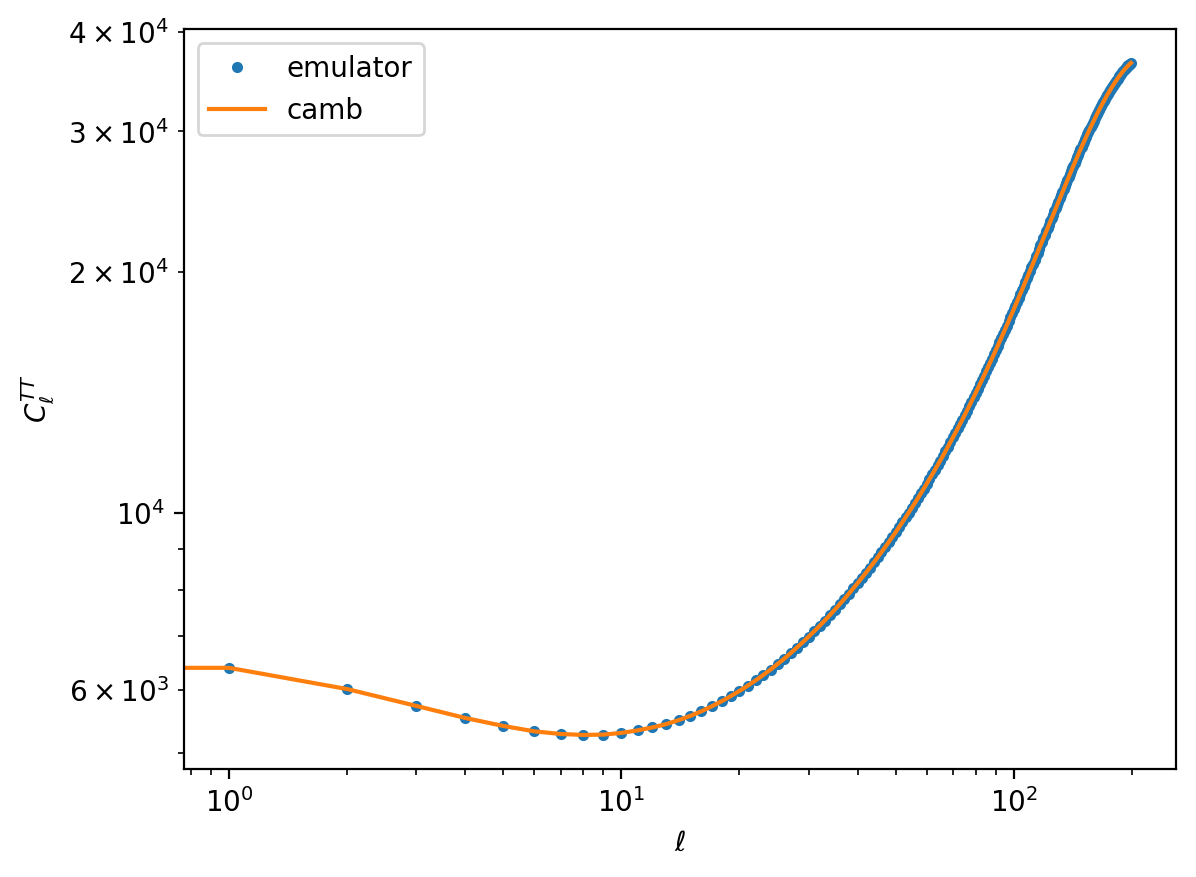

In [53]:
#Plot out one example to compare the difference between emulator and camb

ell=np.arange(2,202,1)
plt.plot(testing_results[100]*ell*(ell+1),'.',label='emulator')
plt.plot(testing_data_vectors[100]*ell*(ell+1),label='camb')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}^{TT}$')
plt.legend()


**MCMC example**

In [58]:
fid=np.load('Demo/fid_demo.npy',allow_pickle=True)[:200]
covinv=np.load('Demo/cosvarinvTT.npy',allow_pickle=True)[:camb_ell_range,:camb_ell_range]
def loglikelihood(omb,omc):
    y=predict(torch.Tensor(np.array([omb,omc])))[0]
    diff=fid-y
    return -0.5*diff@covinv@diff.T

In [59]:
info = {
    "likelihood": {"banana": loglikelihood},
    "params": dict([
        ("omb", {
            "prior": {"min": 0.001, "max": 0.05},
            "ref":0.02,
            "proposal":0.021,
            "latex": r"\Omega_bh^2"}),
        ("omc", {
            "prior": {"min": 0.01, "max": 0.2},
            "ref":0.1,
            "proposal":0.11,
            "latex": r"\Omega_ch^2"})]),
    
    "sampler": {
        "mcmc": {"Rminus1_stop": 0.01, "max_tries": 1000,"covmat": [[ 5.44518053e-06,-1.59976383e-05],[-1.59976383e-05,5.38742228e-05]],"covmat_params":["omb","omc"]}}
        }

In [60]:
from getdist.gaussian_mixtures import GaussianND
from getdist import plots, MCSamples

import getdist

from cobaya.run import run


from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt

In [61]:
from cobaya.run import run

updated_info, sampler = run(info)

[banana] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {banana: 4.72}
[mcmc] Initial point: omb:0.02, omc:0.1
[mcmc] Covariance matrix loaded for params ['omb', 'omc']
[mcmc] All parameters' covariance loaded from given covmat.
[mcmc] Sampling!
[mcmc] Progress @ 2024-09-20 14:34:03 : 1 steps taken, and 0 accepted.
[mcmc] Progress @ 2024-09-20 14:35:04 : 446 steps taken, and 36 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.097
[mcmc]  - Convergence of means: R-1 = 1.779271 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Progress @ 2024-09-20 14:36:04 : 919 steps taken, and 103 accepted.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.196
[mcmc]  - Convergence of means: R-1 = 0.604489 after 128 accepted steps
[mcmc]  - Up

[root] *WARNING* outlier fraction 0.018 


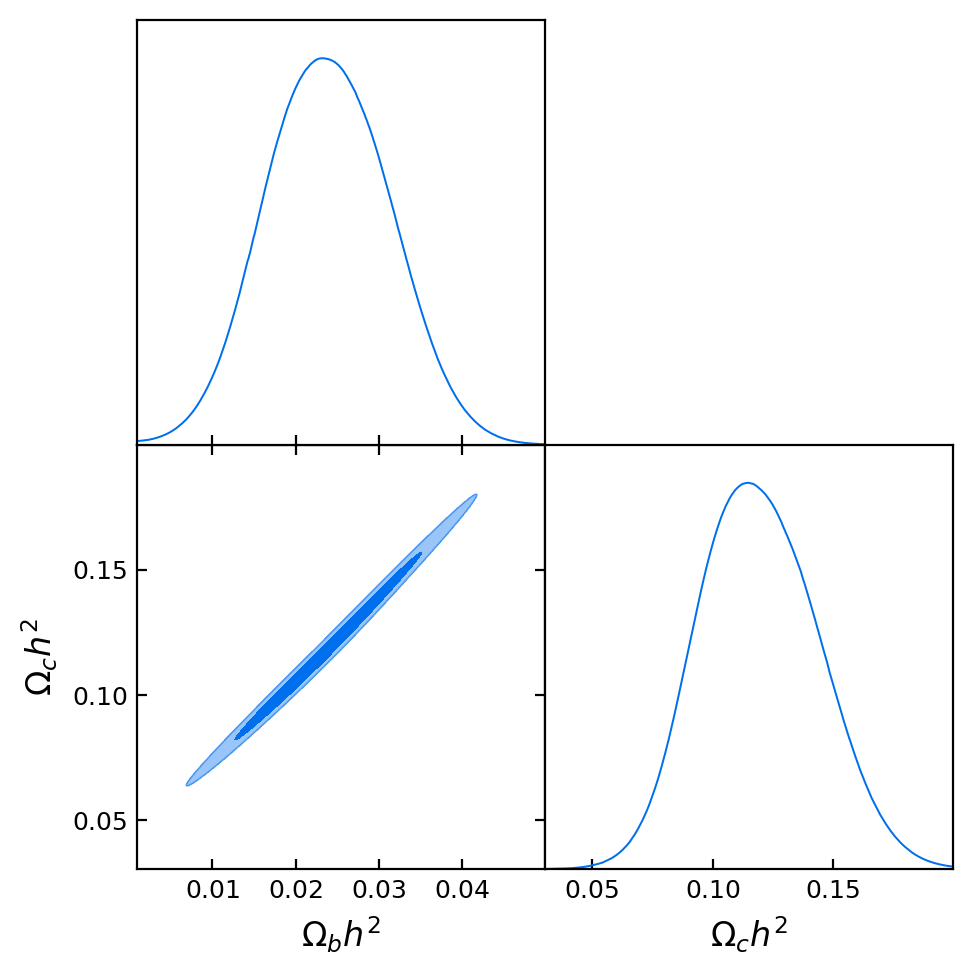

In [62]:
%matplotlib inline

gdsamples = MCSamplesFromCobaya(updated_info, sampler.products()["sample"])
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples, ["omb","omc"], filled=True)